In [1]:
# Load and Prepare Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data_preprocessed.csv')

In [3]:
# Drop 'Negatif' sentiment from dataframe
df = df[df['sentiment'] != 'Netral']
print(f"Total comments after dropping Netral: {len(df)}")
print(f"\nRemaining sentiment distribution:")
print(df['sentiment'].value_counts())

Total comments after dropping Netral: 876

Remaining sentiment distribution:
sentiment
Positif    695
Negatif    181
Name: count, dtype: int64


EXPLORATORY DATA ANALYSIS

Label Distribution:
----------------------------------------
Positif   :  695 ( 79.3%)
Netral    :    0 (  0.0%)
Negatif   :  181 ( 20.7%)


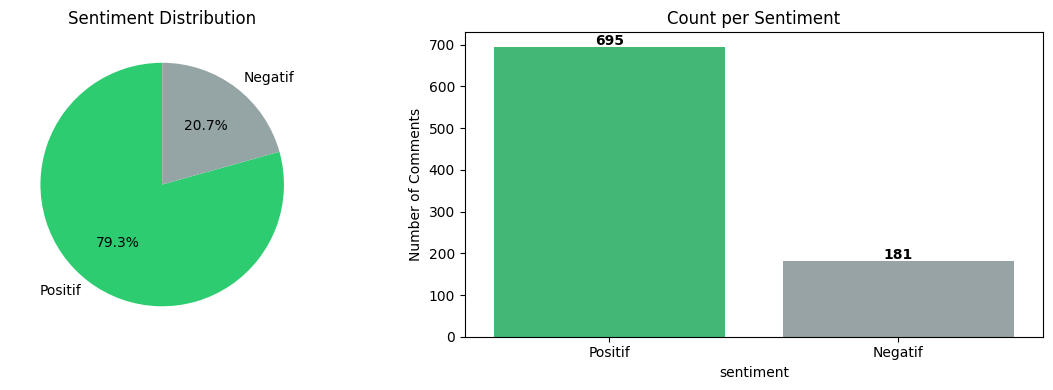


Text Length Statistics:
----------------------------------------
Min: 1, Max: 226, Mean: 18.8


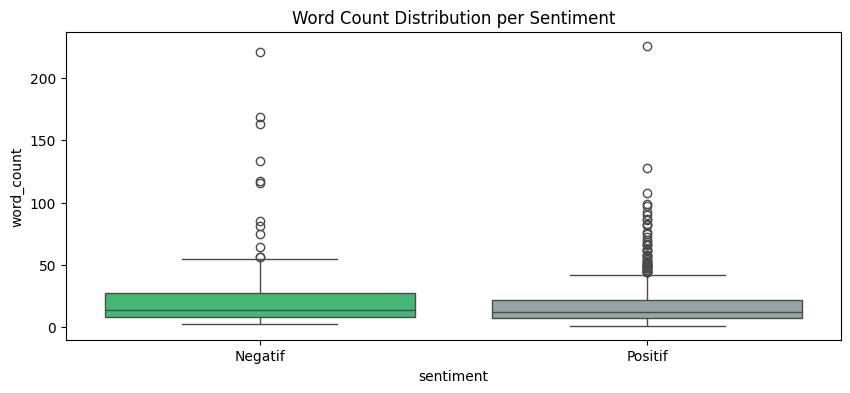


Top 10 Words per Sentiment:
----------------------------------------


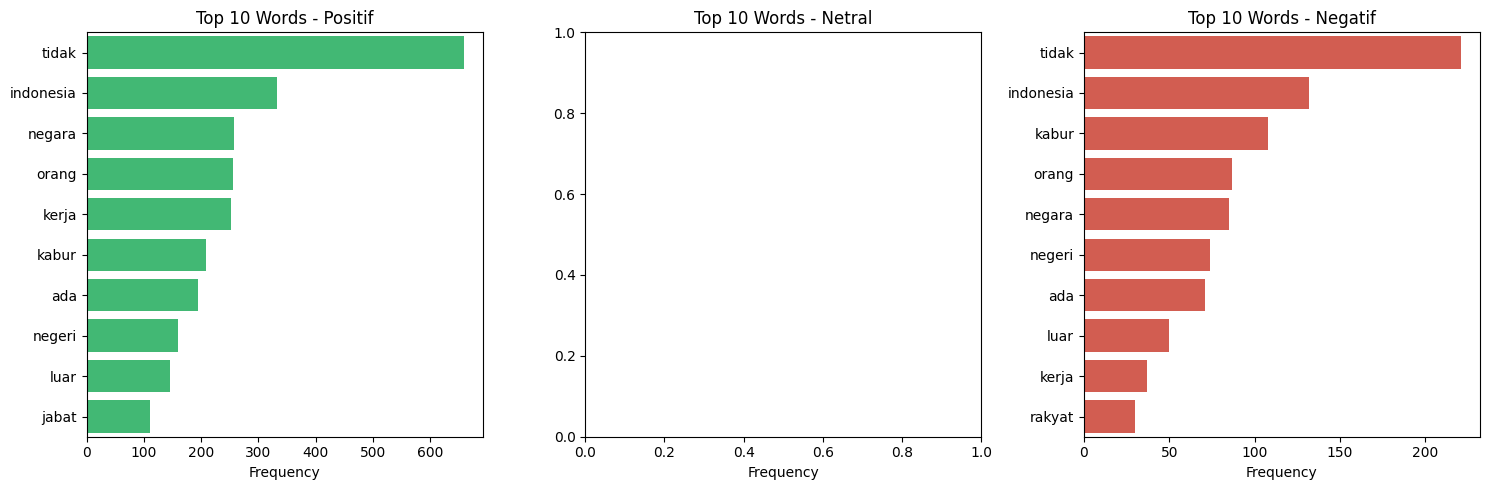


Negation Tags:
----------------------------------------
Total: 0 | Unique: 0

Key Findings:
- Imbalanced data: Positif (79.3%) >> Negatif (20.7%)
- Average word count: 18.8
- Negation tags detected: 0


In [4]:
# Exploratory Data Analysis
print("="*60)
print("EXPLORATORY DATA ANALYSIS")
print("="*60)

# Label distribution
print("\nLabel Distribution:")
print("-"*40)
label_counts = df['sentiment'].value_counts()
label_pct = df['sentiment'].value_counts(normalize=True) * 100

for label in ['Positif', 'Netral', 'Negatif']:
    count = label_counts.get(label, 0)
    pct = label_pct.get(label, 0)
    print(f"{label:<10}: {count:>4} ({pct:>5.1f}%)")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
colors = ['#2ecc71', '#95a5a6', '#e74c3c']

axes[0].pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', 
            colors=colors, startangle=90)
axes[0].set_title('Sentiment Distribution')

sns.barplot(x=label_counts.index, y=label_counts.values, palette=colors, ax=axes[1])
axes[1].set_title('Count per Sentiment')
axes[1].set_ylabel('Number of Comments')
for i, v in enumerate(label_counts.values):
    axes[1].text(i, v + 5, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Text length statistics
print("\nText Length Statistics:")
print("-"*40)
df['word_count'] = df['teks_final'].str.split().str.len()
print(f"Min: {df['word_count'].min()}, Max: {df['word_count'].max()}, Mean: {df['word_count'].mean():.1f}")

fig, ax = plt.subplots(figsize=(10, 4))
sns.boxplot(data=df, x='sentiment', y='word_count', palette=colors, ax=ax)
ax.set_title('Word Count Distribution per Sentiment')
plt.show()

# Top words per sentiment
print("\nTop 10 Words per Sentiment:")
print("-"*40)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, sentiment in enumerate(['Positif', 'Netral', 'Negatif']):
    all_words = ' '.join(df[df['sentiment'] == sentiment]['teks_final']).split()
    word_freq = Counter(all_words).most_common(10)
    
    if word_freq:
        words, counts = zip(*word_freq)
        sns.barplot(x=list(counts), y=list(words), ax=axes[idx], color=colors[idx])
    axes[idx].set_title(f'Top 10 Words - {sentiment}')
    axes[idx].set_xlabel('Frequency')

plt.tight_layout()
plt.show()

# Negation tags analysis
print("\nNegation Tags:")
print("-"*40)
all_tokens = ' '.join(df['teks_final']).split()
negation_tags = [t for t in all_tokens if t.startswith('TIDAK_')]
print(f"Total: {len(negation_tags)} | Unique: {len(set(negation_tags))}")

print("\n" + "="*60)
print("Key Findings:")
print("="*60)
print(f"- Imbalanced data: Positif ({label_pct.get('Positif', 0):.1f}%) >> Negatif ({label_pct.get('Negatif', 0):.1f}%)")
print(f"- Average word count: {df['word_count'].mean():.1f}")
print(f"- Negation tags detected: {len(negation_tags)}")

In [5]:
# Train-Test Split
from sklearn.model_selection import train_test_split

X = df['teks_final']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train: {len(X_train)} | Test: {len(X_test)}")
print(f"\nTrain distribution:")
print(y_train.value_counts())
print(f"\nTest distribution:")
print(y_test.value_counts())

Train: 700 | Test: 176

Train distribution:
sentiment
Positif    555
Negatif    145
Name: count, dtype: int64

Test distribution:
sentiment
Positif    140
Negatif     36
Name: count, dtype: int64


In [6]:
# Setup Model Pipelines
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

tfidf_params = {
    'ngram_range': (1, 2),
    'max_features': 5000,
    'min_df': 2,
    'max_df': 0.95
}

pipelines = {
    'SVM': Pipeline([
        ('tfidf', TfidfVectorizer(**tfidf_params)),
        ('clf', SVC(kernel='linear', C=1.0, class_weight='balanced'))
    ]),
    'Logistic Regression': Pipeline([
        ('tfidf', TfidfVectorizer(**tfidf_params)),
        ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
    ]),
    'Random Forest': Pipeline([
        ('tfidf', TfidfVectorizer(**tfidf_params)),
        ('clf', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42))
    ]),
    'Naive Bayes': Pipeline([
        ('tfidf', TfidfVectorizer(**tfidf_params)),
        ('clf', MultinomialNB())
    ])
}

print("Pipelines created successfully")

Pipelines created successfully


CROSS-VALIDATION (5-Fold, Stratified)
SVM                      : F1-Macro = 0.635 (+/- 0.028)
Logistic Regression      : F1-Macro = 0.651 (+/- 0.055)
Random Forest            : F1-Macro = 0.540 (+/- 0.053)
Naive Bayes              : F1-Macro = 0.483 (+/- 0.032)


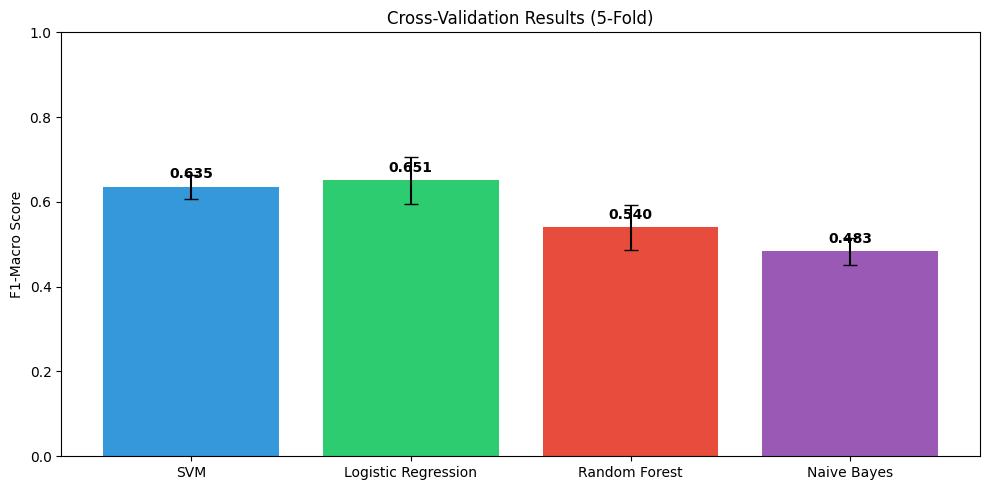


Best Model: Logistic Regression (F1-Macro = 0.651)


In [7]:
# Cross-Validation
from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("="*60)
print("CROSS-VALIDATION (5-Fold, Stratified)")
print("="*60)

cv_results = {}

for name, pipeline in pipelines.items():
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1_macro')
    cv_results[name] = {
        'mean': scores.mean(),
        'std': scores.std(),
        'scores': scores
    }
    print(f"{name:<25}: F1-Macro = {scores.mean():.3f} (+/- {scores.std():.3f})")

fig, ax = plt.subplots(figsize=(10, 5))
names = list(cv_results.keys())
means = [cv_results[n]['mean'] for n in names]
stds = [cv_results[n]['std'] for n in names]

bars = ax.bar(names, means, yerr=stds, capsize=5, color=['#3498db', '#2ecc71', '#e74c3c', '#9b59b6'])
ax.set_ylabel('F1-Macro Score')
ax.set_title('Cross-Validation Results (5-Fold)')
ax.set_ylim(0, 1)

for bar, mean in zip(bars, means):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
            f'{mean:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

best_model_name = max(cv_results, key=lambda x: cv_results[x]['mean'])
print(f"\nBest Model: {best_model_name} (F1-Macro = {cv_results[best_model_name]['mean']:.3f})")

TEST SET EVALUATION

--------------------------------------------------
SVM
--------------------------------------------------
              precision    recall  f1-score   support

     Negatif       0.37      0.31      0.33        36
     Positif       0.83      0.86      0.85       140

    accuracy                           0.75       176
   macro avg       0.60      0.58      0.59       176
weighted avg       0.73      0.75      0.74       176



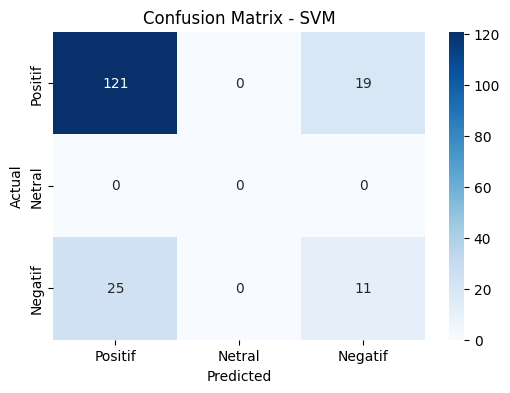


--------------------------------------------------
Logistic Regression
--------------------------------------------------
              precision    recall  f1-score   support

     Negatif       0.36      0.33      0.35        36
     Positif       0.83      0.85      0.84       140

    accuracy                           0.74       176
   macro avg       0.60      0.59      0.59       176
weighted avg       0.74      0.74      0.74       176



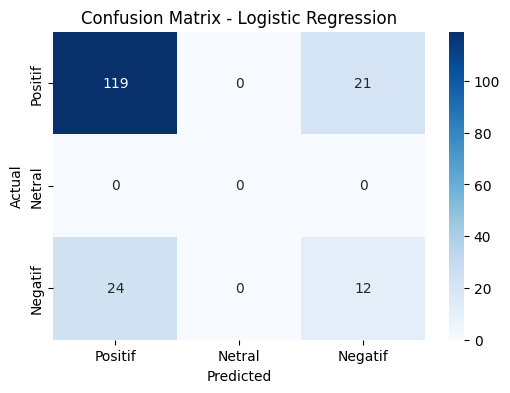


--------------------------------------------------
Random Forest
--------------------------------------------------
              precision    recall  f1-score   support

     Negatif       0.60      0.08      0.15        36
     Positif       0.81      0.99      0.89       140

    accuracy                           0.80       176
   macro avg       0.70      0.53      0.52       176
weighted avg       0.76      0.80      0.74       176



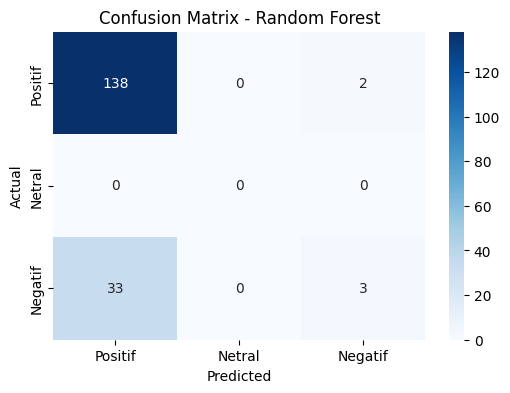


--------------------------------------------------
Naive Bayes
--------------------------------------------------
              precision    recall  f1-score   support

     Negatif       1.00      0.03      0.05        36
     Positif       0.80      1.00      0.89       140

    accuracy                           0.80       176
   macro avg       0.90      0.51      0.47       176
weighted avg       0.84      0.80      0.72       176



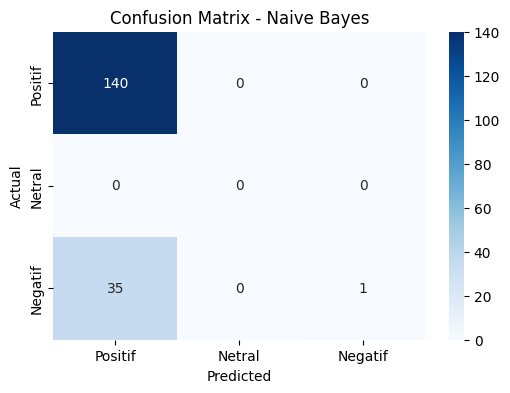


SUMMARY
Logistic Regression      : F1-Macro = 0.594
SVM                      : F1-Macro = 0.590
Random Forest            : F1-Macro = 0.517
Naive Bayes              : F1-Macro = 0.471


In [8]:
# Test Set Evaluation
from sklearn.metrics import classification_report, confusion_matrix, f1_score

print("="*60)
print("TEST SET EVALUATION")
print("="*60)

test_results = {}

for name, pipeline in pipelines.items():
    print(f"\n{'-'*50}")
    print(f"{name}")
    print('-'*50)
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    f1 = f1_score(y_test, y_pred, average='macro')
    test_results[name] = {
        'f1_macro': f1,
        'y_pred': y_pred,
        'report': classification_report(y_test, y_pred, output_dict=True)
    }
    
    print(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred, labels=['Positif', 'Netral', 'Negatif'])
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Positif', 'Netral', 'Negatif'],
                yticklabels=['Positif', 'Netral', 'Negatif'])
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

print("\n" + "="*60)
print("SUMMARY")
print("="*60)
for name, result in sorted(test_results.items(), key=lambda x: x[1]['f1_macro'], reverse=True):
    print(f"{name:<25}: F1-Macro = {result['f1_macro']:.3f}")

HYPERPARAMETER TUNING - SVM
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Best Parameters:
clf__C: 1
clf__kernel: linear
tfidf__ngram_range: (1, 1)

Best CV Score: 0.668

BEST MODEL TEST RESULTS
              precision    recall  f1-score   support

     Negatif       0.36      0.33      0.35        36
     Positif       0.83      0.85      0.84       140

    accuracy                           0.74       176
   macro avg       0.60      0.59      0.59       176
weighted avg       0.74      0.74      0.74       176



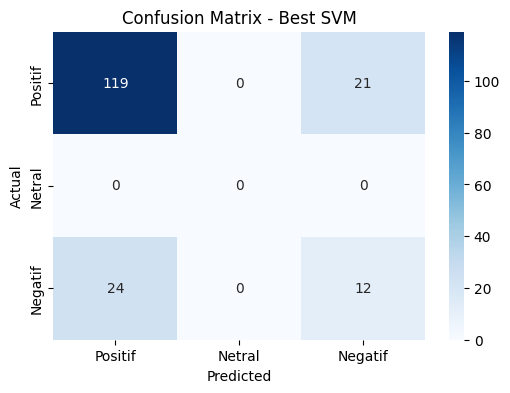

In [9]:
# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

print("="*60)
print("HYPERPARAMETER TUNING - SVM")
print("="*60)

svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', SVC(class_weight='balanced'))
])

param_grid = {
    'clf__C': [0.1, 1, 10],
    'clf__kernel': ['linear'],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
}

grid_search = GridSearchCV(
    svm_pipeline,
    param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"\nBest Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")
print(f"\nBest CV Score: {grid_search.best_score_:.3f}")

best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

print(f"\n{'='*60}")
print("BEST MODEL TEST RESULTS")
print("="*60)
print(classification_report(y_test, y_pred_best))

cm = confusion_matrix(y_test, y_pred_best, labels=['Positif', 'Netral', 'Negatif'])
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Positif', 'Netral', 'Negatif'],
            yticklabels=['Positif', 'Netral', 'Negatif'])
plt.title('Confusion Matrix - Best SVM')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

ERROR ANALYSIS

Total errors: 45 of 176 (25.6%)

----------------------------------------
Error Types:
----------------------------------------
 actual predicted  count
Negatif   Positif     24
Positif   Negatif     21


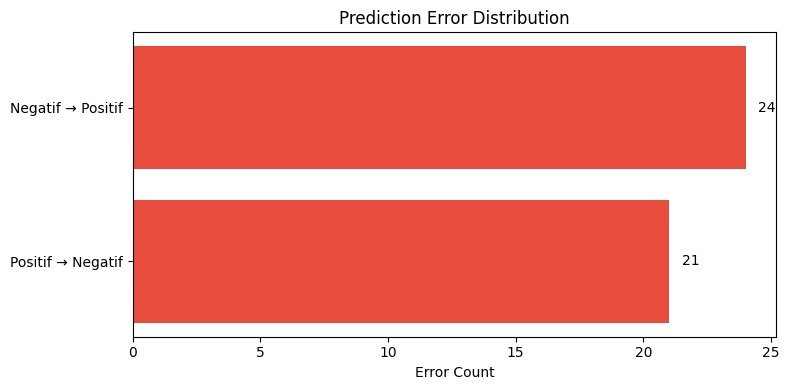


----------------------------------------
Sample Errors:
----------------------------------------

[Negatif → Positif]
1. abal abal nasionalisme silah kabur menggelaneang luar negeri
2. hehehe kabur kabur indo tidak ada ganti xari
3. maaf mulut tindak mas panji bukti kabur gagal new york alas terkadang orang lupa mulut banding kuali...

[Positif → Negatif]
1. video nji orang kais rejeki luar negeri sumbang negara indonesia devisa rupiah ratus ribu juta org s...
2. cinta negara tidak suka pemerintah
3. orang pintar kalah orang milik uang koneksi muka tembok lihat hasil test ptn cpns dll akademis milik...


In [10]:
# Error Analysis
print("="*60)
print("ERROR ANALYSIS")
print("="*60)

errors_df = pd.DataFrame({
    'teks': X_test.values,
    'actual': y_test.values,
    'predicted': y_pred_best
})
errors_df = errors_df[errors_df['actual'] != errors_df['predicted']]

print(f"\nTotal errors: {len(errors_df)} of {len(X_test)} ({len(errors_df)/len(X_test)*100:.1f}%)")

print("\n" + "-"*40)
print("Error Types:")
print("-"*40)
error_types = errors_df.groupby(['actual', 'predicted']).size().reset_index(name='count')
error_types = error_types.sort_values('count', ascending=False)
print(error_types.to_string(index=False))

fig, ax = plt.subplots(figsize=(8, 4))
error_labels = [f"{row['actual']} → {row['predicted']}" for _, row in error_types.iterrows()]
ax.barh(error_labels, error_types['count'], color='#e74c3c')
ax.set_xlabel('Error Count')
ax.set_title('Prediction Error Distribution')
ax.invert_yaxis()
for i, v in enumerate(error_types['count']):
    ax.text(v + 0.5, i, str(v), va='center')
plt.tight_layout()
plt.show()

print("\n" + "-"*40)
print("Sample Errors:")
print("-"*40)
for _, row in error_types.head(3).iterrows():
    actual, predicted = row['actual'], row['predicted']
    samples = errors_df[(errors_df['actual'] == actual) & (errors_df['predicted'] == predicted)]['teks'].head(3)
    print(f"\n[{actual} → {predicted}]")
    for i, text in enumerate(samples, 1):
        print(f"{i}. {text[:100]}{'...' if len(text) > 100 else ''}")

COMPARISON: CLASS_WEIGHT vs SMOTE

CV Results:
SVM + SMOTE        : F1-Macro = 0.645 (+/- 0.045)
SVM + class_weight : F1-Macro = 0.635 (+/- 0.028)

----------------------------------------
SMOTE Test Results:
----------------------------------------
              precision    recall  f1-score   support

     Negatif       0.38      0.28      0.32        36
     Positif       0.83      0.89      0.86       140

    accuracy                           0.76       176
   macro avg       0.61      0.58      0.59       176
weighted avg       0.74      0.76      0.75       176



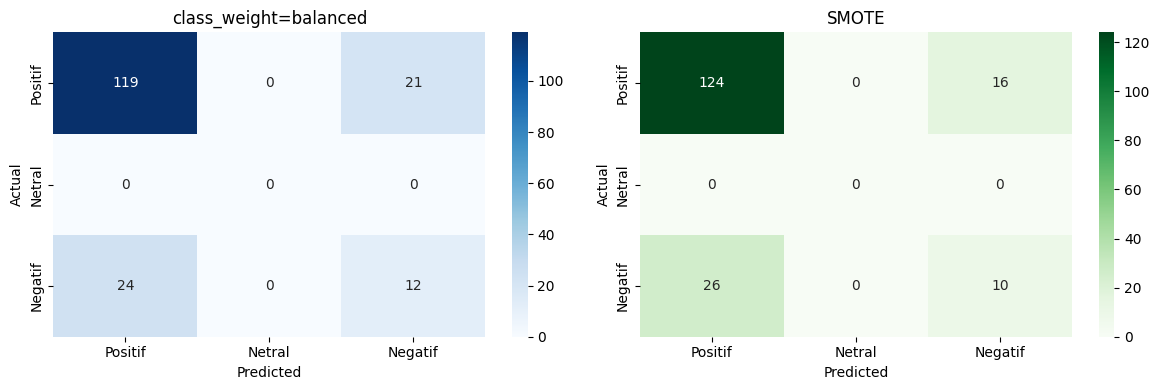


Test F1-Macro: class_weight=0.594 | SMOTE=0.589


In [11]:
# SMOTE Comparison
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

print("="*60)
print("COMPARISON: CLASS_WEIGHT vs SMOTE")
print("="*60)

smote_pipeline = ImbPipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('smote', SMOTE(random_state=42)),
    ('clf', SVC(kernel='linear', C=1.0))
])

scores_smote = cross_val_score(smote_pipeline, X_train, y_train, cv=cv, scoring='f1_macro')
print(f"\nCV Results:")
print(f"SVM + SMOTE        : F1-Macro = {scores_smote.mean():.3f} (+/- {scores_smote.std():.3f})")
print(f"SVM + class_weight : F1-Macro = {cv_results['SVM']['mean']:.3f} (+/- {cv_results['SVM']['std']:.3f})")

smote_pipeline.fit(X_train, y_train)
y_pred_smote = smote_pipeline.predict(X_test)

print("\n" + "-"*40)
print("SMOTE Test Results:")
print("-"*40)
print(classification_report(y_test, y_pred_smote))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

cm_balanced = confusion_matrix(y_test, y_pred_best, labels=['Positif', 'Netral', 'Negatif'])
cm_smote = confusion_matrix(y_test, y_pred_smote, labels=['Positif', 'Netral', 'Negatif'])

sns.heatmap(cm_balanced, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Positif', 'Netral', 'Negatif'],
            yticklabels=['Positif', 'Netral', 'Negatif'])
axes[0].set_title('class_weight=balanced')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

sns.heatmap(cm_smote, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Positif', 'Netral', 'Negatif'],
            yticklabels=['Positif', 'Netral', 'Negatif'])
axes[1].set_title('SMOTE')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

f1_balanced = f1_score(y_test, y_pred_best, average='macro')
f1_smote = f1_score(y_test, y_pred_smote, average='macro')
print(f"\nTest F1-Macro: class_weight={f1_balanced:.3f} | SMOTE={f1_smote:.3f}")

In [12]:
# Save Final Model
import joblib
from datetime import datetime

f1_balanced = f1_score(y_test, y_pred_best, average='macro')
f1_smote = f1_score(y_test, y_pred_smote, average='macro')

print("="*60)
print("FINAL MODEL SELECTION")
print("="*60)
print(f"class_weight='balanced': {f1_balanced:.3f}")
print(f"SMOTE                  : {f1_smote:.3f}")

if f1_balanced >= f1_smote:
    final_model = best_model
    final_method = 'class_weight=balanced'
    final_f1 = f1_balanced
else:
    final_model = smote_pipeline
    final_method = 'SMOTE'
    final_f1 = f1_smote

print(f"\nSelected: {final_method} (F1={final_f1:.3f})")

model_metadata = {
    'model': final_model,
    'method': final_method,
    'best_params': grid_search.best_params_ if final_method == 'class_weight=balanced' else None,
    'cv_score': grid_search.best_score_ if final_method == 'class_weight=balanced' else scores_smote.mean(),
    'test_f1_macro': final_f1,
    'train_size': len(X_train),
    'test_size': len(X_test),
    'label_distribution': y.value_counts().to_dict(),
    'tfidf_params': tfidf_params,
    'timestamp': datetime.now().isoformat()
}

joblib.dump(model_metadata, 'model_sentiment_svm_v2.joblib')

print("\n" + "="*60)
print("Model saved: model_sentiment_svm_v2.joblib")
print("="*60)

FINAL MODEL SELECTION
class_weight='balanced': 0.594
SMOTE                  : 0.589

Selected: class_weight=balanced (F1=0.594)

Model saved: model_sentiment_svm_v2.joblib
